In [1]:
import numpy as np
from IPython.display import Latex

from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

# Deutsch Problem

The Deutsch Problem is a simple "toy" example of how a problem that takes exponential time in classical computing takes only polynomial time when solved (in a fundamentally different way) with quantum computing. In this notebook, we'll look at the Deutsch problem at a high level, as well as the generalization to the Deutsch-Jozsa problem.

## Problem Description

Take a binary map function $f: x \in \{0,1\} \rightarrow f(x) = y \in \{0,1\}$. Any function $f$ can be **constant** or **balanced**, defined as:

* Balanced: $f(x)$ yields the same result for all inputs; $\forall\ x \in \{0, 1\},\ \ f(x) = y$
  * For the simple 1-bit input, this corresponds to 2 possible definitions of $f$:
    * $f(x) = 0$
    * $f(x) = 1$
* Constant: $f(x)$ yields 0 for half of inputs, and 1 for the other half
  * For the simple 1-bit input, this corresponds to 2 possible definitions of $f$:
    * $f(x) = x$
    * $f(x) = \bar{x} = x \oplus 1$, where $\oplus$ is XOR/addition modulo 2 ("flip the bit")
    
In the Deutsch problem, we aim to find out whether a given function $f$ is constant or balanced.

## Classical Solution

How do we solve the Deutsch problem with classical computers? We must evaluate the function $f$ for both possible inputs, as we can't tell if $f$ is constant or balanced without knowing what both outputs are. For example, given a function $f$, first we evaluate $f(0)$ = 1. We can't tell if the function is constant or balanced, but we can after evaluating $f(1)$.

Let's define the functions above in Python and choose one to evaluate at random. Can you tell whether the function is constant or balanced after evaluating only $f(0)$?

In [2]:
f1 = lambda x: 0
f2 = lambda x: 1
f3 = lambda x: x
f4 = lambda x: (x + 1) % 2

funcs = [f1, f2, f3, f4]

In [3]:
test_func = funcs[np.random.randint(4)]
test_func(0)

0

In [4]:
test_func(1)

0

## Quantum Solution

We've now demonstrated that the classical solution to the Deutsch problem requires 2 executions. However, with quantum computing, we make this determination by evaluating the function **only one time** by leveraging superposition to effectively, garner some global knowledge about the function as if it were applied to all inputs simultaneously. Let's explore how this is done.

### Oracle Functions

Firstly, we must set up our problem in a way that is compatible with quantum computers. Specifically, we need to be able to run our function $f$ such that it:

* Operates on Qubits
* Is reversible

To do this, we need to use a 2-qubit system (of qubits $x$ and $y$) and a 2 qubit matrix to represent the function $f$. We need the additional (ancilla) qubit in order to ensure that the function is reversible when applied to the quantum circuit. We refer to this matrix representation of the function we are evaluating as the **oracle function** $U_f$. In order to be reversible, this 2 qubit system needs to operate as follows:

$$
U_f: |x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x)\rangle
$$

### Circuit Setup

The quantum circuit used to solve the Deutsch problem is pictured below:

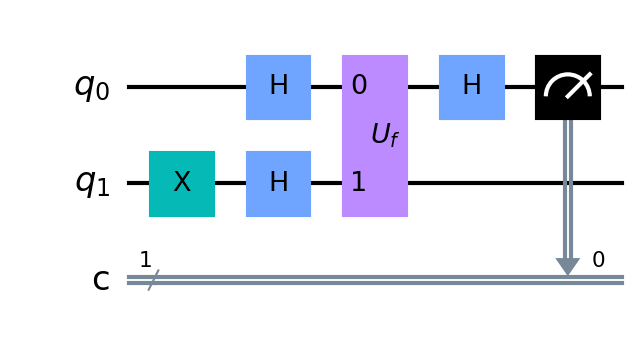

In [5]:
circuit = QuantumCircuit(2, 1)
circuit.x(1)
circuit.h((0,1))
circuit.unitary(np.identity(4), (0,1), '$U_f$') # 4x4 identity matrix as example
circuit.h(0)
circuit.measure(0, 0)
circuit.draw('mpl', justify='right', scale=1.5)

This circuit consists of the following (in order):

* Input qubit ($|x\rangle$, $q_0$) initialized to $|0\rangle$
* Ancilla qubit ($|y\rangle$, $q_1$) initialized to $|1\rangle$ (IE, with $X$ gate)
* Hadamard gates applied to each qubit
* 2-qubit oracle/unitary function $U_f$
* Final Hadamard gate applied to $q_0$
* Measurement of $q_0$

Without going into many details (and mathderivation), when we execute this circuit, we can discover whether the function is constant or balanced as follows:

* If $q_0$ is measured to be 0, then the function is guaranteed to be constant.
* If $q_0$ is measured to be 1, then the function is guaranteed to be balanced.

Let's look at some examples of this in action.

## Example

For this example, we'll use $f(x) = x$ as our "balanced" function. The logic table of the function, is as follows:

| $$x$$ | $$f(x)$$ |
|:-:|:----:|
| 0 | 0 |
| 1 | 1 |

Let's extend this table to include the second qubit and the result of the orcale function $U_f$ when evaluating this function:

| $$x$$ | $$y$$ | $$f(x)$$ | $$y \oplus f(x)$$ |
|:-----:|:-----:|:--------:|:-----------------:|
|   0   |   0   |    0     |         0         |
|   0   |   1   |    0     |         1         |
|   1   |   0   |    1     |         1         |
|   1   |   1   |    1     |         0         |

Conveniently, we can represent this function with the CNOT gate, as it implements this exact logic table. So, for this function, $U_f = CNOT$ We can manually compute the different states of a 2-qubit system when operated on by the CNOT gate below:

In [6]:
# Gate definitions
cnot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
cnot

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [7]:
# Showing how CNOT gate changes basis states for a 2-qubit system
result_table = []
for index in range(4):
    instate = np.array([[1 if j == index else 0] for j in range(4)])
    result = cnot @ instate
    result_table.append((instate, result))

for result_tuple in result_table:
    instate_tex = Statevector(result_tuple[0]).draw('latex_source')
    result_tex = Statevector(result_tuple[1]).draw('latex_source')
    display(Latex('$CNOT \otimes {} = {}$'.format(instate_tex, result_tex)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

From the output above, we can see that the CNOT gate, when applied to different 2-qubit state vectors, matches our logic table above.

Let's actually evaluate whether or not this function is balanced using the circuit we defined before. Here's our updated circuit using the CNOT gate as $U_f$:

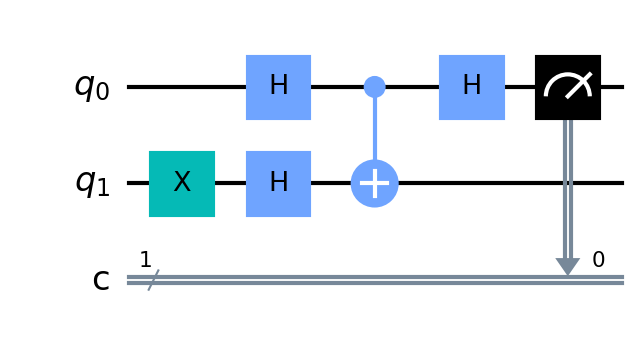

In [8]:
circuit = QuantumCircuit(2, 1)
circuit.x(1)
circuit.h((0, 1))

# Switch which of the following lines is commented out to try different oracle functions
circuit.cnot(0, 1)
# circuit.unitary(np.identity(4, int), (0, 1), 'Identity')

circuit.h(0)
circuit.measure(0, 0)
circuit.draw('mpl', justify='right', scale=1.5)

When we actually execute this circuit (1,024 times), we can observe the results:

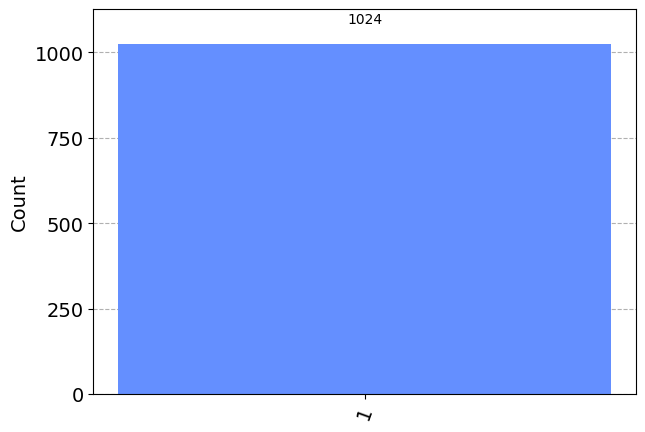

In [9]:
sim_backend = Aer.get_backend('qasm_simulator')

job = sim_backend.run(transpile(circuit, sim_backend), shots=1024)
result = job.result()

counts = result.get_counts()

plot_histogram(counts)

And we see that the result is 1, so we can conclude that our function $f(x) = x$ is indeed balanced, by only evaluating the circuit **a single time!**

Try changing the unitary function defined above to the 4x4 identity matrix, which is the oracle function representation of the function $f(x) = 0$. What is the output of the circuit now? Does it mean that the function is constant or balanced?

## Why Does this Work?

Without delving too deeply into the math, we can represent the state vector of our system after the unitary function $U_f$ is applied as the following:

$$
\begin{align}
    |\psi_3\rangle &= \frac{1}{\sqrt{2}} (-1)^{f(x)}|x\rangle|-\rangle\\
    &= \frac{1}{\sqrt{2}} \left((-1)^{f(0)}|0\rangle|-\rangle + (-1)^{f(1)}|1\rangle|-\rangle\right)
\end{align}
$$

The term $(-1)^{f(x)}$ is referred to as the *global phase kickback*, and is a common element of many different quantum elements. Effectively, this is a global characteristic of the function being evaluated (through applying the oracle function $U_f$) that reveals some information about the function (in this case, its being constant or balanced).

As an exercise, try evaluating the equation above with the values for $f$ that correspond to our two example functions $f(x) = 0$ and $f(x) = x$. What are the corresponding probabilities of the first qubit being measured as a 0 or 1? What happens when you apply the final Hadamard gate to the first qubit?

This global phase kickback enables us to make our determination with only a single evaluation of the circuit.

# Generalizing Deutsch to Deutsch-Jozsa

We've seen how we can solve the Deutsch problem in half the steps on a quantum computer than with a classical computer. The Deutsch problem can be generalized from a 1-input function to an $n$-input function, known as the Deutsch-Jozsa problem. The fundamental problem setup is the same; given a function $f: x \in \{0, 1\}^n \rightarrow f(x) = y \in \{0, 1\}$, we aim to determine if $f$ is constant or balanced, according to the same definitions:

* $f$ is constant if the output for all inputs $x$ is the same.
* $f$ is balanced if (exactly) half the outputs are 0, and (exactly) the other half are 1.

## Classical Solution (Exponential Time!)

To solve the DJ problem on classical computers, we must evaluate $2^{n - 1} + 1$ inputs before we can determine that the function is constant or balanced. Notice that this holds for the Deutsch problem, where $n = 1$. Why? Imagine a function $f$ that, for the first $\frac{n}{2}$ inputs, yields 0. Is this function constant or balanced? What if the function yields 1 for the $\frac{n}{2} + 1$ input? We must evaluate it to be certain. Therefore, this problem can only be solved on classical computers in **exponential time.**

## Quantum Solution

The quantum computing solution, on the other hand, still deterines if the function $f$ is constant or balanced with **only a single execution** of the quantum circuit, producing an exponentially faster solution!

The quantum circuit for the DJ algorithm is depicted (in a generalized way) below:

![DJ Circuit](./images/Generic_Deutsch-Jozsa_Circuit.png)

Notice that there are now $n$ input qubits and still a single ancilla qubit that is initialized to $|1\rangle$

The code below creates this general circuit for `n` input qubits; here 2 are shown. Change the value of `n` to see larger circuits.

In [10]:
n = 2

### Multi-Qubit Oracles

For a simple example, we define a constant and a balanced oracle as follows:

* Constant: The Identity gate for $n + 1$ qubits.
* Balanced: As implemented in the Qiskit textbook, we use a number of CNOT gates applied with the input qubits as control and the ancilla qubit as the target.
  * We also randomly flip different control bits before applying the CNOT gates (as well as after).
  
The orcale portions of our circuit are defined below:

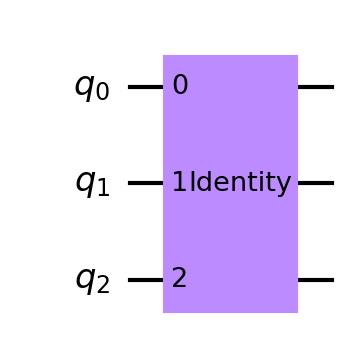

In [11]:
constant_oracle = QuantumCircuit(n + 1)
constant_oracle.unitary(np.identity(2 ** (n + 1), int), range(n + 1), 'Identity')
constant_oracle.draw('mpl', justify='right', scale=1.5)

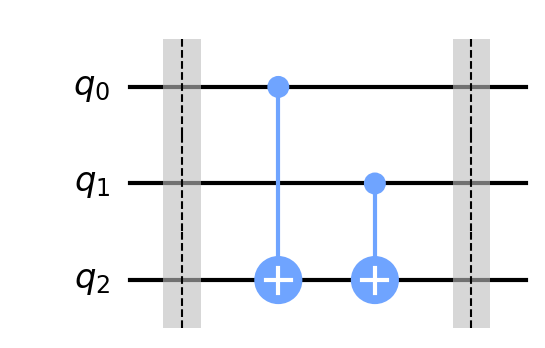

In [12]:
rand_flips = np.random.choice(n, np.random.randint(n + 1), replace=False)

balanced_oracle = QuantumCircuit(n + 1)
for flip in rand_flips:
    balanced_oracle.x(flip)
balanced_oracle.barrier()
for i in range(n):
    balanced_oracle.cnot(i, n)
balanced_oracle.barrier()
for flip in rand_flips:
    balanced_oracle.x(flip)
balanced_oracle.draw('mpl', justify='right', scale=1.5)

### Putting It All Together

With the components we defined above, we can create our full circuit of $n + 1$ qubits:

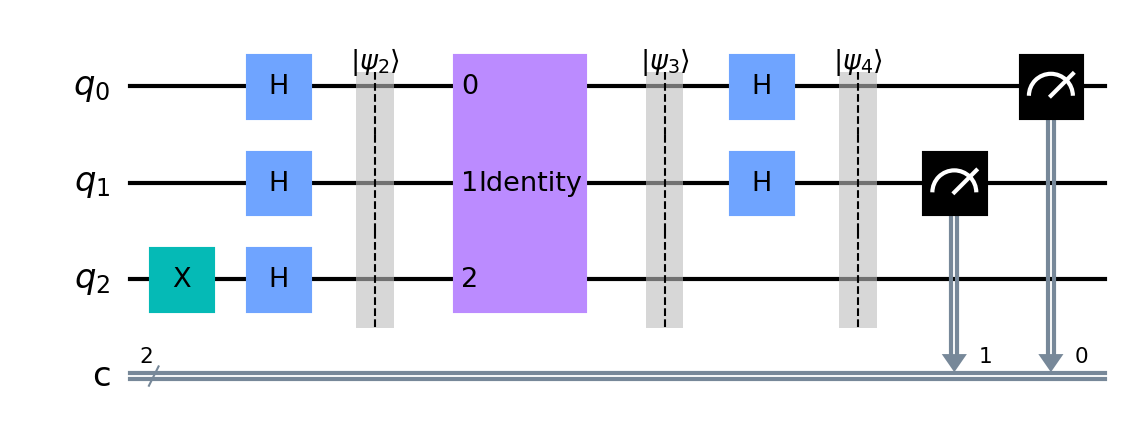

In [13]:
dj_circuit = QuantumCircuit(n + 1, n)
dj_circuit.x(n)
dj_circuit.h(range(n + 1))

dj_circuit.barrier(label='$|\\psi_2\\rangle$')
# Switch which of the following lines is commented out to try different oracle functions
dj_circuit = dj_circuit.compose(constant_oracle)
# dj_circuit = dj_circuit.compose(balanced_oracle)
dj_circuit.barrier(label='$|\\psi_3\\rangle$')

dj_circuit.h(range(n))
dj_circuit.barrier(label='$|\\psi_4\\rangle$')
for i in range(n):
    dj_circuit.measure(i, i)
dj_circuit.draw('mpl', justify='right', scale=1.5)

Use the code below to again run the circuit above on the Qiskit simulator and observe the results. For reference, here are the possible outcomes:

* If the result of measuring the $n$ input qubits is $|0^{\otimes n}\rangle$, then the function is constant.
* If the result of this measurement is anything else, the function is balanced.
  * In other words, when there is a **0% probability** of measuring $|0^{\otimes n}\rangle$, then the function is balanced.
  
Experiment with the code above, changing the oracle function or defining your own.

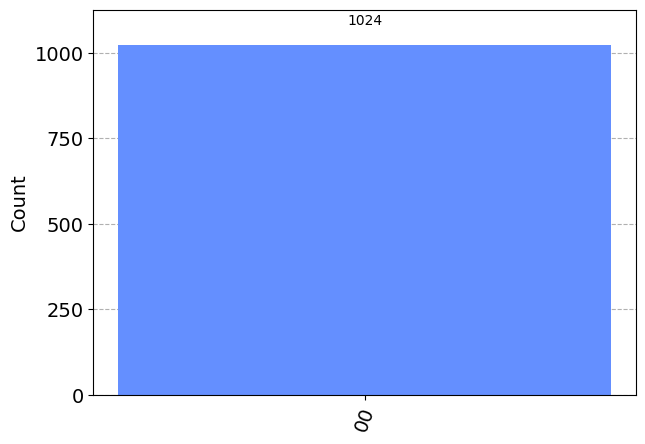

In [14]:
sim_backend = Aer.get_backend('qasm_simulator')

job = sim_backend.run(transpile(dj_circuit, sim_backend), shots=1024)
result = job.result()

counts = result.get_counts()

plot_histogram(counts)

# Resources & References

* [Useful derivation of the Deutsch-Jozsa algorithm (VCU)](https://people.vcu.edu/~sgharibian/courses/CMSC491/notes/Lecture%206%20-%20Deutsch's%20algorithm.pdf)
* [Qiskit Texbook on DJ](https://learn.qiskit.org/course/ch-algorithms/deutsch-jozsa-algorithm)